In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from matplotlib import rc
rc("font", family="serif", size=11)

In [121]:
output = pd.read_csv('../data/output_1000stars.csv', usecols=range(1,4))
ID = 11754056
#ID = random.choice(output['ID'])
star = output.loc[(output['ID'] == ID)]

star



,ID,Numax,Numax_err
67,11754056,33.23349,0.293786


In [122]:
modes = pd.read_csv('../data/rgbmodes/modes_'+str(ID)+'.csv', usecols=['f0', 'f0_err', 'A0'])

modes = modes.sort_values(by=['f0'])
modes = modes.set_index(np.arange(0,len(modes),1))
modes['dnu'] = (modes['f0'].diff(2).shift(-1))/2
dnu_avg = np.mean(modes['dnu'])
n_min = int(modes['f0'].min() / dnu_avg)

n = np.arange(n_min, n_min+len(modes), 1)
modes.insert(loc=0, column='n', value=n)


modes

,n,f0,A0,f0_err,dnu
0,5,24.988203,-0.589385,0.030842,NaN
1,6,28.887269,0.350973,0.012404,4.004407
2,7,32.997018,0.411578,0.015937,4.158792
3,8,37.204854,0.408908,0.029021,4.229610
4,9,41.456238,0.101419,0.028243,4.272704
5,10,45.750261,-1.003081,0.078039,NaN


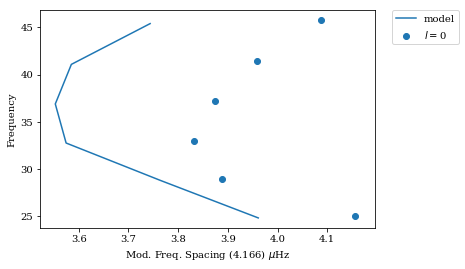

In [123]:
def model(n, dnu, nmax, epsilon, k, A, omega, phi, tau):
    freqs = (n + epsilon) * dnu
    freqs += (nmax-n)**2 * k
    freqs += A*np.sin(omega*n + phi)*np.exp(-n/tau)
    return freqs

#dnu_avg = 4.2

nmax = 8
epsilon = 0.85
k = 0.05
A = 0.07
omega = 3
phi = 1.5
tau = 10

f = model(n, dnu_avg, nmax, epsilon, k, A, omega, phi, tau)

plt.scatter(modes['f0'] % dnu_avg, modes['f0'], label=r'$l=$'+str(0))
plt.plot(f % dnu_avg, f, label='model')
plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [49]:
code = '''
functions {
    real model(real n, real dnu, real nmax, real epsilon, real k, real A, real omega, real phi, real tau){
        return (dnu*(n+epsilon) + k*(nmax - n)^2 + A*sin(omega*n + phi)*exp(-n/tau));
    }
}
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {
    real<lower = 0> dnu;
    real<lower = 0> nmax;
    real epsilon;
    real k;
    real<lower = 0> A;
    real<lower = 0> omega;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    real<lower = 0> tau;
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = model(n[i], dnu, nmax, epsilon, k, A, omega, phi, tau);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    nmax ~ normal(11,2);
    epsilon ~ normal(0.77, 0.1);
    k ~ lognormal(log(0.03), 0.3);
    A ~ lognormal(log(0.2), 0.3);
    omega ~ normal(3, 0.5);
    tau ~ normal(10,5);
    // phi ~ normal(0, 1.5);
    
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26f60c38e65fe186037548447b2d0a40 NOW.


In [124]:
stan_data = {'N': len(modes['n'].values),
             'n': modes['n'].values, 
             'freq': (modes['f0'].values),
             'freq_err': modes['f0_err'].values,
             'dnu_guess': dnu_avg
            }
start = {'dnu': dnu_avg,
         'nmax': nmax,
         'epsilon': epsilon,
         'k': k,
         'A': A,
         'omega': omega,
         'phi': phi,
         'tau': tau
        }
nchains = 4

fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)],)
                  #control=dict(max_treedepth=15))

In [125]:
print(fit)

Inference for Stan model: anon_model_26f60c38e65fe186037548447b2d0a40.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.17  1.2e-4 4.2e-3   4.16   4.16   4.17   4.17   4.18   1234    1.0
nmax      7.42    0.04   0.18   7.18   7.31    7.4   7.49   7.88     24   1.16
epsilon   0.92  3.8e-4 9.3e-3    0.9   0.91   0.92   0.93   0.94    608   1.01
k         0.04  6.1e-4 7.0e-3   0.03   0.04   0.04   0.05   0.06    128   1.04
A         0.19  1.5e-3   0.06    0.1   0.15   0.18   0.23   0.32   1541    1.0
omega     2.76    0.17   0.76   1.28   2.21   2.83   3.36   4.11     20   1.23
phi       0.21    0.76   4.04  -6.12  -3.54   0.19   4.25    6.0     28   1.13
tau       5.97    0.19   3.07   1.99   3.82   5.32   7.28  13.92    266   1.02
lp__     -0.66    0.25   2.41   -6.3  -2.08  -0.29   1.13   2.91     94   1.05

Samples were drawn 

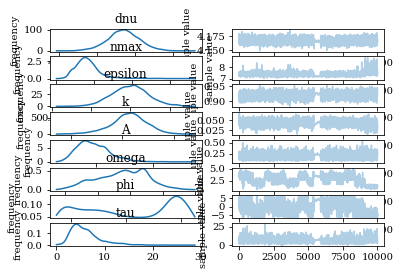

In [126]:
fit.plot()
plt.show()

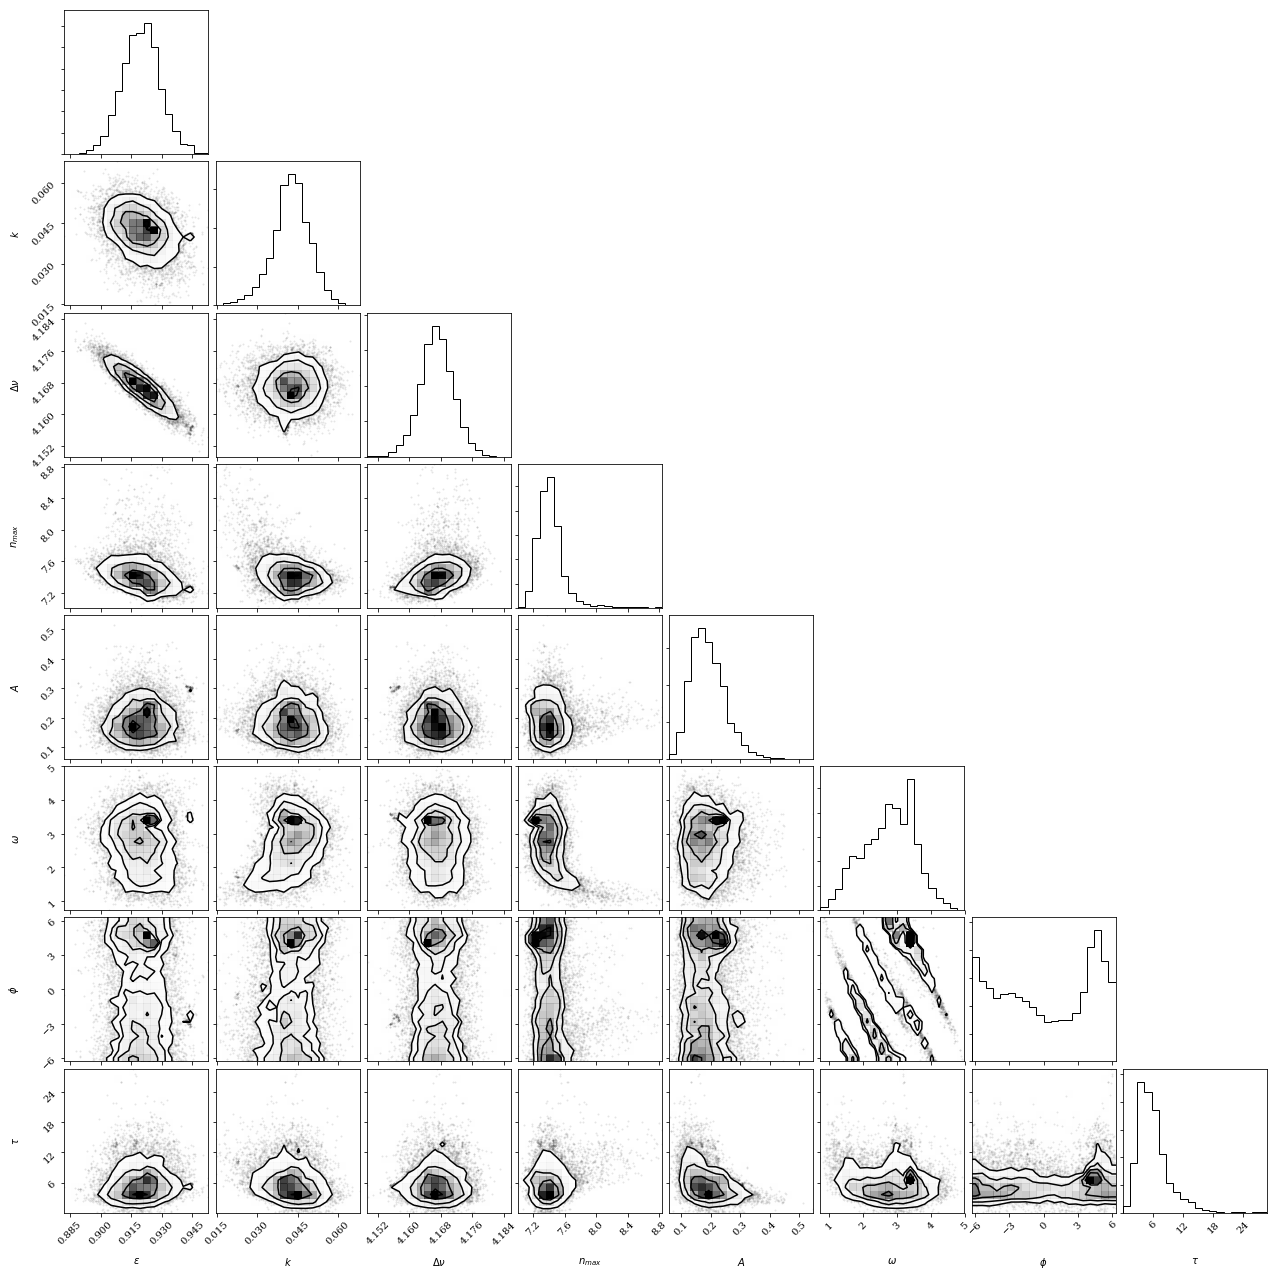

In [127]:
import corner
data = np.vstack([fit['epsilon'], fit['k'], fit['dnu'], fit['nmax'],
                  fit['A'], fit['omega'], fit['phi'], fit['tau']]).T
corner.corner(data, labels=[r'$\epsilon$', r'$k$',r'$\Delta\nu$',r'$n_{max}$',
                            r'$A$', r'$\omega$', r'$\phi$', r'$\tau$'])
              #, truths=[1.436, 0.07, 0.3, 2, 0])
plt.show()

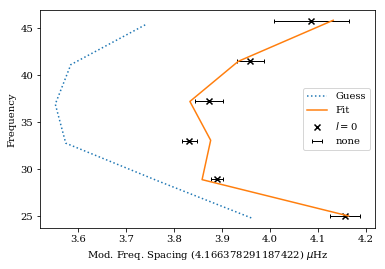

In [128]:
#n = np.arange(12,30,1)

plt.figure(4)
plt.scatter(modes['f0'] % dnu_avg, modes['f0'], c='k', marker='x', label=r'$l=$'+str(0))
plt.errorbar(modes['f0'] % dnu_avg, modes['f0'], xerr=modes['f0_err'], zorder=0, fmt="none", label="none",
             c='k', capsize=2, markersize=4, elinewidth=1)

g = model(n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(),
          fit['A'].mean(), fit['omega'].mean(), fit['phi'].mean(), fit['tau'].mean())
plt.plot(f % dnu_avg, f, ':', label='Guess')
plt.plot(g % fit['dnu'].mean(), g, label='Fit')
#plt.plot(g % dnu, g, label='Fit')

plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(dnu_avg) +') $\mu$Hz')
#plt.xlim(58,68)
plt.legend()
plt.show()